#Importing all the required packages


In [86]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Importing the datasets


In [87]:
df = pd.read_csv('Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250527.csv')

#Convertion and Sorting


In [88]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)
df['Other'].fillna(df['Other'].median(), inplace=True)

#Generating the future forecast


In [93]:
def forecast_service(data, column, days=7):
    model_data = data[[column]].copy()
    model_data['Target'] = model_data[column].shift(-days)
    model_data.dropna(inplace=True)

    X = model_data[[column]]
    y = model_data['Target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    future_input = data[[column]].iloc[-1].values.reshape(1, -1)
    forecast = []
    for _ in range(days):
        pred = model.predict(future_input)[0]
        forecast.append(pred)
        future_input = np.array([[pred]])

    future_dates = pd.date_range(data.index.max() + timedelta(days=1), periods=days)
    forecast_df = pd.DataFrame({column: forecast}, index=future_dates)

    return forecast_df, mae, rmse


#Combinig and ploting the forecast

Local Route → MAE: 2258.10, RMSE: 4211.49
Light Rail → MAE: 1391.98, RMSE: 2304.89
Peak Service → MAE: 57.81, RMSE: 108.69
Rapid Route → MAE: 2839.41, RMSE: 4861.02
School → MAE: 1145.43, RMSE: 1844.84


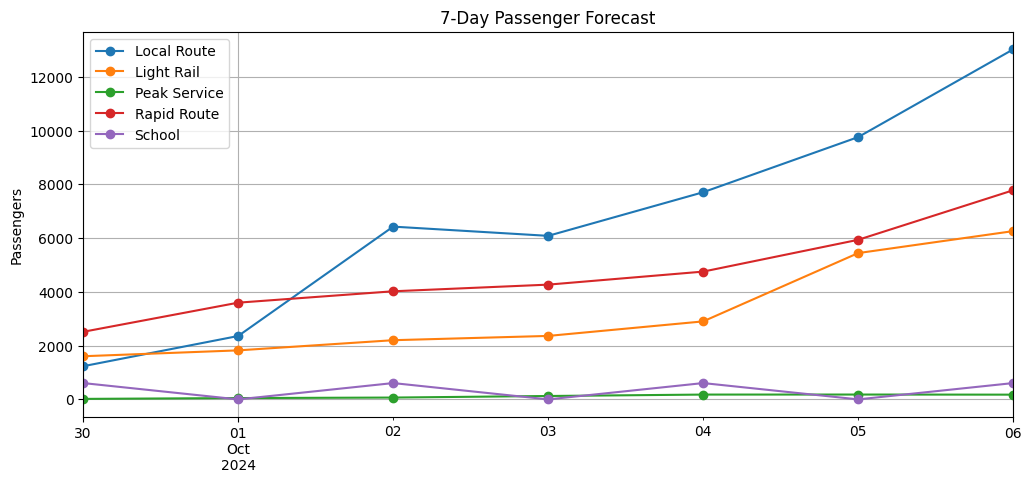

In [94]:
services = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']
forecast_results = {}
metrics = {}

for service in services:
    forecast_df, mae, rmse = forecast_service(df, service)
    forecast_results[service] = forecast_df
    metrics[service] = {'MAE': mae, 'RMSE': rmse}
    print(f"{service} → MAE: {mae:.2f}, RMSE: {rmse:.2f}")

forecast_combined = pd.concat(forecast_results.values(), axis=1)
forecast_combined.columns = services

forecast_combined.plot(figsize=(12, 5), marker='o', title="7-Day Passenger Forecast")
plt.grid(True)
plt.ylabel("Passengers")
plt.show()


In [92]:
import os
output_dir = "outputs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

forecast_combined.to_csv("outputs/7_day_forecast.csv")
pd.DataFrame(metrics).T.to_csv("outputs/model_metrics.csv")